Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [137]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as npc
from models import *

import torch
import torch.optim

from torch.autograd import Variable
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [138]:
## deJPEG 
fname = 'data/denoising/snail.jpg'

## denoising
# fname = 'data/denoising/F16_GT.png'

# Load image

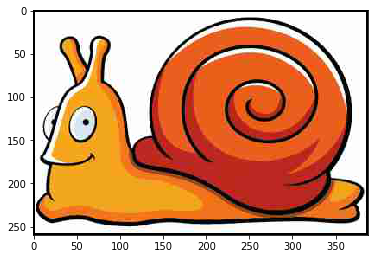

In [139]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [140]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 500
"""
num_channels_down = [8, 16, 32, 64, 128], 
num_channels_up   = [8, 16, 32, 64, 128],
else:
    assert False
num_channels_skip = [0, 0, 0, 4, 4], 
"""


if fname == 'data/denoising/F16_GT.png':
    num_iter = 1800
    input_depth = 32 
    figsize = 4 
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    num_iter=1800
    input_depth = 32
    figsize = 4 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [128, 128, 128, 128, 128], 
                num_channels_up   = [128, 128, 128, 128, 128], 
                num_channels_skip = [4, 4, 4, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_var(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

Starting optimization with ADAM


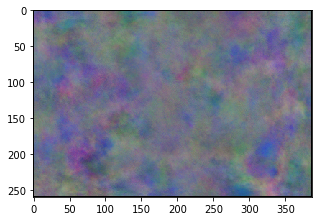

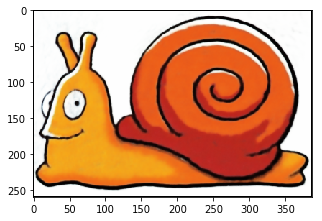

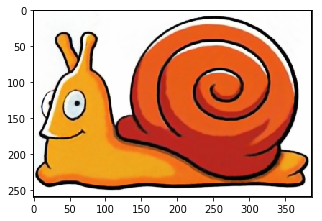

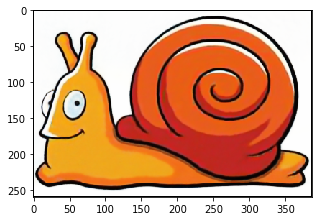

In [141]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()


i = 0
def closure():
    
    global i
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
   
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = var_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

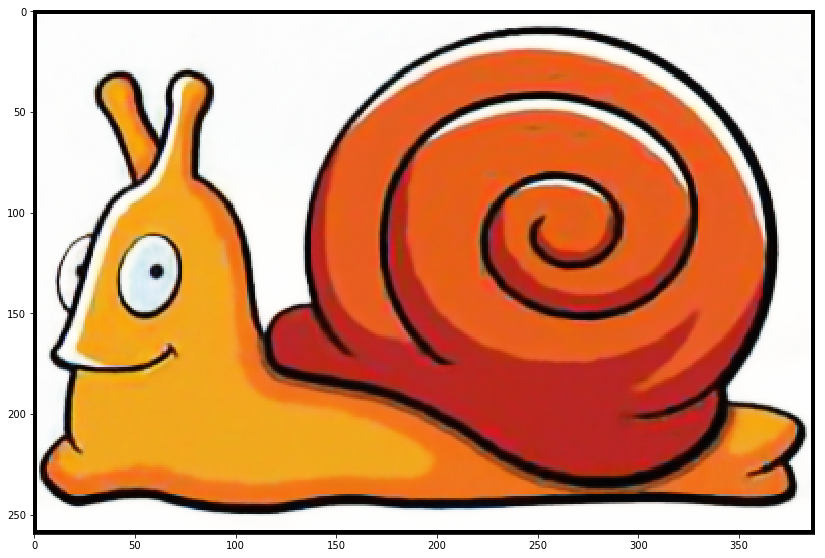

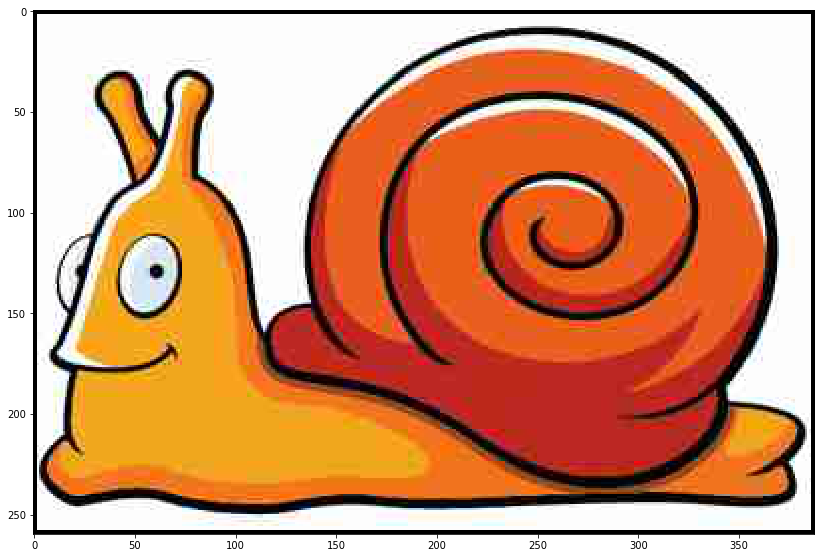

In [142]:
out_np = var_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1)], factor=13);
p = plot_image_grid([img_np], factor=13);

In [145]:
import skimage.measure
from scipy import misc

psnr = skimage.measure.compare_psnr(p, q)
print(psnr)

29.7021553885751
